<a href="https://colab.research.google.com/github/redpineK/deeplearning/blob/master/6%EC%9D%BC%EC%B0%A83%EA%B0%95_GAN%EC%8B%A4%EC%8A%B52_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
print(keras.__version__)

2.8.0


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 입력을 16 × 16 크기의 128개 채널을 가진 특성 맵으로 변환합니다
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# 합성곱 층을 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기로 업샘플링합니다
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기의 1개 채널을 가진 특성 맵을 생성합니다
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      104883

In [ ]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# 드롭아웃 층을 넣는 것이 아주 중요합니다!
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용합니다
# 안정된 훈련을 위해서 학습률 감쇠를 사용합니다
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6, 6, 128)         0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# 판별자의 가중치가 훈련되지 않도록 설정합니다(gan 모델에만 적용됩니다)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan.summary()
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 32, 32, 3)         6264579   
                                                                 
 model_1 (Functional)        (None, 1)                 790913    
                                                                 
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


170508288/170498071 [==============================] - 16s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


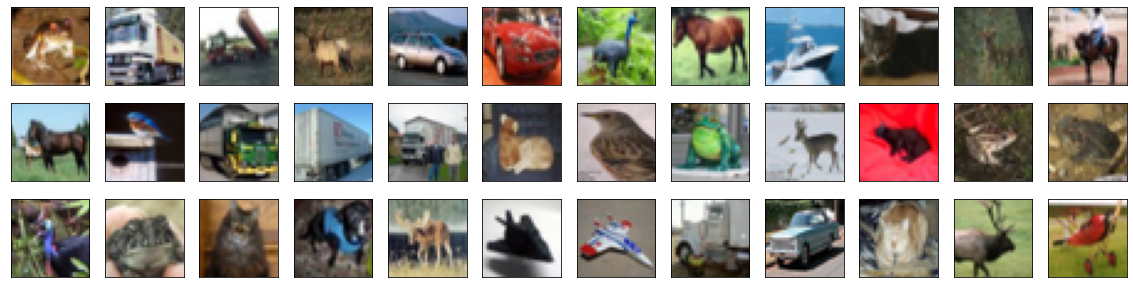

In [ ]:
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

(x_train, y_train) , (x_test, y_test) = cifar10.load_data()

print(x_train.shape)
print(x_test.shape)

fig = plt.figure(figsize=(20,5))

for i in range(36):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i])

In [ ]:
import os
from tensorflow.keras.preprocessing import image

# CIFAR10 데이터를 로드합니다
# (x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 개구리 이미지를 선택합니다(클래스 6)
x_train = x_train[y_train.flatten() == 6]

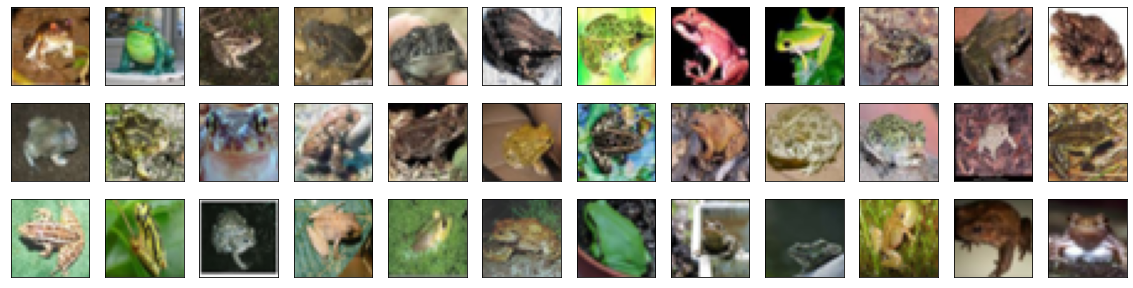

In [ ]:

fig = plt.figure(figsize=(20,5))

for i in range(36):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i])

random_latent_vectors.shape :  (20, 32)


generated_images.shape :  (20, 32, 32, 3)


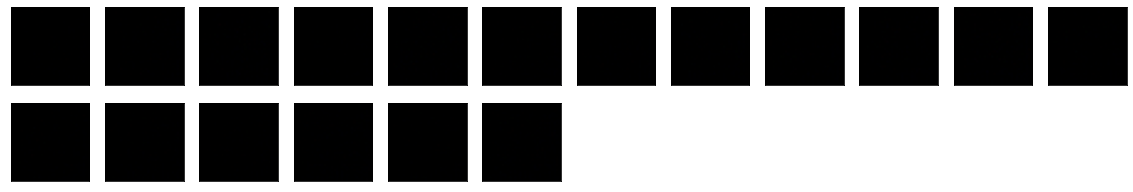

In [ ]:
import matplotlib.pyplot as plt

batch_size = 20
start = 0
# 잠재 공간에서 무작위로 포인트를 샘플링합니다

random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
print("random_latent_vectors.shape : ", random_latent_vectors.shape) 
# 가짜 이미지를 디코딩합니다
generated_images = generator.predict(random_latent_vectors)
print("generated_images.shape : ", generated_images.shape)

fig = plt.figure(figsize=(20,5))

for i in range(18):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(generated_images[i])

readl_images.shape :  (20, 32, 32, 3)


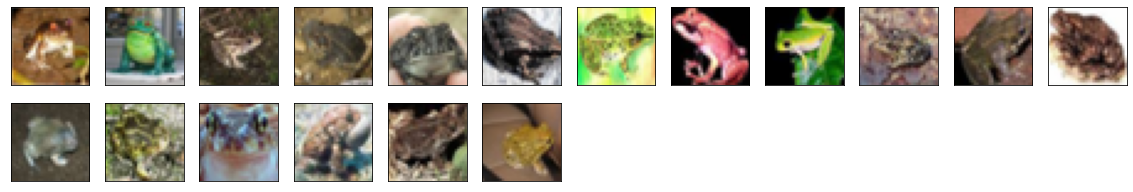

In [ ]:
stop = start + batch_size
real_images = x_train[start: stop]

print("readl_images.shape : ", real_images.shape)

fig = plt.figure(figsize=(20,5))

for i in range(18):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(real_images[i])

combined_images.shape :  (40, 32, 32, 3)


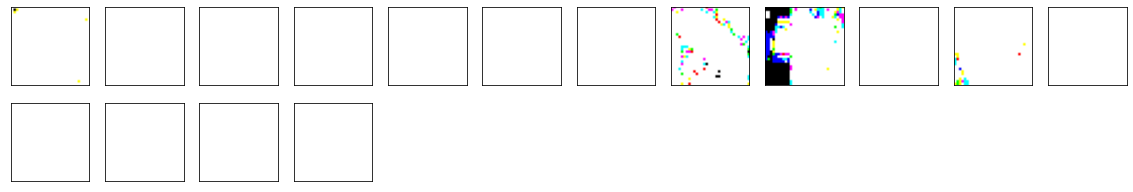

In [ ]:
combined_images2 = np.concatenate([real_images, generated_images])
print("combined_images.shape : ", combined_images2.shape)
# 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
fig = plt.figure(figsize=(20,5))

for i in range(16):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(combined_images2[i])

In [ ]:
labels = np.concatenate([np.ones((batch_size, 1)),np.zeros((batch_size, 1))])
print("labels.shape : ", labels.shape)
print(labels)
# 레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!
labels += 0.05 * np.random.random(labels.shape)
print(labels)

labels.shape :  (40, 1)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[1.00244992]
 [1.02107977]
 [1.00571106]
 [1.00888464]
 [1.03701821]
 [1.0485145 ]
 [1.04351955]
 [1.03179982]
 [1.02347906]
 [1.02678276]
 [1.04118301]
 [1.02481529]
 [1.03110912]
 [1.04474868]
 [1.01276751]
 [1.02485196]
 [1.01792324]
 [1.03505319]
 [1.02580313]
 [1.01771239]
 [0.00378026]
 [0.00521374]
 [0.0475998 ]
 [0.04458132]
 [0.00862332]
 [0.02472252]
 [0.03483882]
 [0.02252328]
 [0.00862753]
 [0.01294145]
 [0.0202044 ]
 [0.02427416]
 [0.03136613]
 [0.03851533]
 [0.0057022 ]
 [0.01232867]
 [0.01438012]
 [0.01190162]
 [0.02002002]
 [0.01763206]]


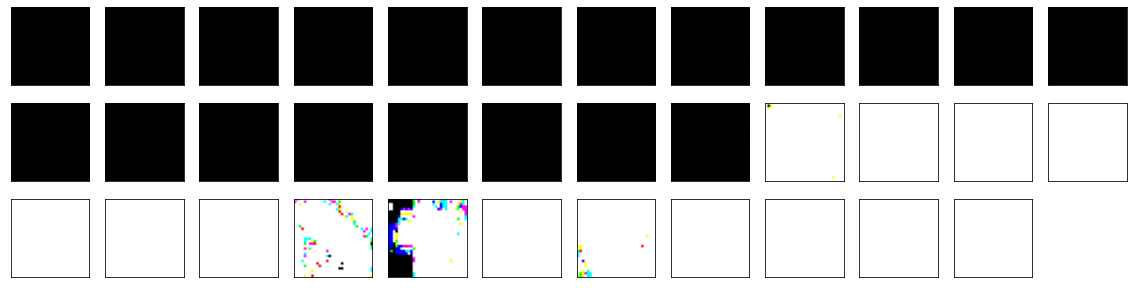

In [ ]:
fig = plt.figure(figsize=(20,5))

for i in range(35):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(combined_images[i])

In [ ]:


# 데이터를 정규화합니다
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './datasets/gan_images/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


# 훈련 반복 시작
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 가짜 이미지를 디코딩합니다
    generated_images = generator.predict(random_latent_vectors)

    # 진짜 이미지와 연결합니다
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!
    labels += 0.05 * np.random.random(labels.shape)

    # discriminator를 훈련합니다
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 “진짜 이미지"라고 레이블을 만듭니다
    misleading_targets = np.zeros((batch_size, 1))

    # generator를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # 중간 중간 저장하고 그래프를 그립니다
    if step % 100 == 0:
        # 모델 가중치를 저장합니다
        gan.save_weights('gan.h5')

        # 측정 지표를 출력합니다
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        # 생성된 이미지 하나를 저장합니다
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 비교를 위해 진짜 이미지 하나를 저장합니다
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

스텝 0에서 판별자 손실: 0.6846297979354858
스텝 0에서 적대적 손실: 0.676542341709137
스텝 100에서 판별자 손실: 0.0034105300437659025
스텝 100에서 적대적 손실: 1.4624080657958984
스텝 200에서 판별자 손실: -0.7817469835281372
스텝 200에서 적대적 손실: 141.59353637695312
스텝 300에서 판별자 손실: -0.22903862595558167
스텝 300에서 적대적 손실: 124.30534362792969


KeyboardInterrupt: ignored

In [ ]:


# 데이터를 정규화합니다
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './datasets/gan_images/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


# 훈련 반복 시작
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 가짜 이미지를 디코딩합니다
    generated_images = generator.predict(random_latent_vectors)

    # 진짜 이미지와 연결합니다
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!
    labels += 0.05 * np.random.random(labels.shape)

    # discriminator를 훈련합니다
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 “진짜 이미지"라고 레이블을 만듭니다
    misleading_targets = np.zeros((batch_size, 1))

    # generator를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # 중간 중간 저장하고 그래프를 그립니다
    if step % 100 == 0:
        # 모델 가중치를 저장합니다
        gan.save_weights('gan.h5')

        # 측정 지표를 출력합니다
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        # 생성된 이미지 하나를 저장합니다
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 비교를 위해 진짜 이미지 하나를 저장합니다
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

-------------------------
(20, 32)
(20, 32, 32, 3)
-------------------------
스텝 0에서 판별자 손실: 0.8194716572761536
스텝 0에서 적대적 손실: 1.1106202602386475
스텝 100에서 판별자 손실: 12.87626838684082
스텝 100에서 적대적 손실: 310.2378845214844
스텝 200에서 판별자 손실: -269.3870849609375
스텝 200에서 적대적 손실: 26435.75390625
스텝 300에서 판별자 손실: -2963.661865234375
스텝 300에서 적대적 손실: 472592.4375
스텝 400에서 판별자 손실: -15504.994140625
스텝 400에서 적대적 손실: 2079158.375


KeyboardInterrupt: ignored

In [ ]:


# 데이터를 정규화합니다
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './datasets/gan_images/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


# 훈련 반복 시작
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 가짜 이미지를 디코딩합니다
    generated_images = generator.predict(random_latent_vectors)

    # 진짜 이미지와 연결합니다
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!
    labels += 0.05 * np.random.random(labels.shape)

    # discriminator를 훈련합니다
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 잠재 공간에서 무작위로 포인트를 샘플링합니다
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 모두 “진짜 이미지"라고 레이블을 만듭니다
    misleading_targets = np.zeros((batch_size, 1))

    # generator를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # 중간 중간 저장하고 그래프를 그립니다
    if step % 100 == 0:
        # 모델 가중치를 저장합니다
        gan.save_weights('gan.h5')

        # 측정 지표를 출력합니다
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

        # 생성된 이미지 하나를 저장합니다
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 비교를 위해 진짜 이미지 하나를 저장합니다
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

-------------------------
(20, 32)
(20, 32, 32, 3)
-------------------------
스텝 0에서 판별자 손실: 0.8194716572761536
스텝 0에서 적대적 손실: 1.1106202602386475
스텝 100에서 판별자 손실: 12.87626838684082
스텝 100에서 적대적 손실: 310.2378845214844
스텝 200에서 판별자 손실: -269.3870849609375
스텝 200에서 적대적 손실: 26435.75390625
스텝 300에서 판별자 손실: -2963.661865234375
스텝 300에서 적대적 손실: 472592.4375
스텝 400에서 판별자 손실: -15504.994140625
스텝 400에서 적대적 손실: 2079158.375


KeyboardInterrupt: ignored

가짜 이미지 몇개를 출력해 보죠:

In [ ]:
import matplotlib.pyplot as plt

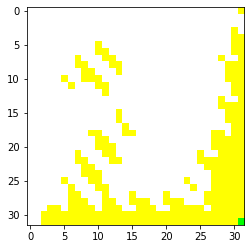

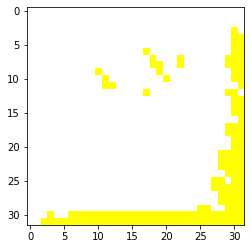

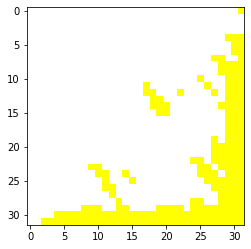

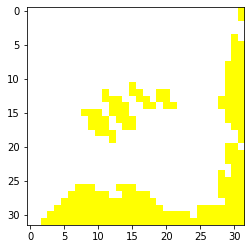

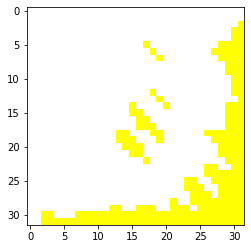

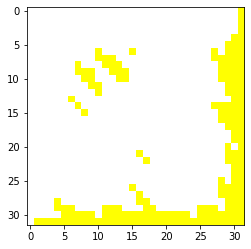

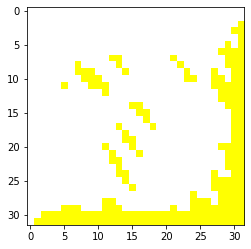

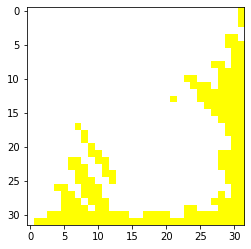

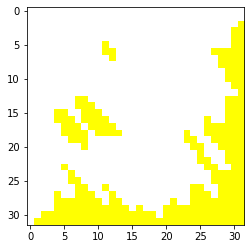

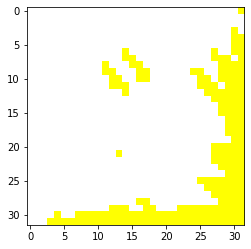

In [ ]:
# 잠재 공간에서 랜덤한 포인트를 샘플링합니다
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 가짜 이미지로 디코딩합니다
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

픽셀 경계가 두드러진 개구리처럼 보이는 이미지를 얻었습니다.